In [1]:
%matplotlib inline

# **Tutorial for stripe removal**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1miOe68e5hAPfBYBvOuGfVAfjuN5xsa42?usp=sharing)

This tutorial shows how to apply Leonardo-DeStripe to remove stripe-shaped shadows in light-sheet data.


The data used here is available in [zenodo](https://zenodo.org/records/14215090). We use volumes "D2_I0.tif" for this tutorial.

## **Import packages & data**

In [ ]:
# in case Leonardo is not installed yet
! pip install leonardo_toolset

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of distributed to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# load sample dataset
import pooch
from pathlib import Path
import tifffile

data_path = "./"

source_part = pooch.retrieve(
    url="https://zenodo.org/records/14215090/files/D2_I0.tif",
    known_hash="md5:83ad8c084f3e8f6d5753ee05a4378bdd",
    fname="D2_I0.tif",
    path=data_path / Path("download"),
)

X = tifffile.imread(source_part)

## **Start destripe**

As a simple demo tutorial, we showcase how to remove stripes for only a slice of testing testing volume X and we choose slice 206, which contains heavy stripes:

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

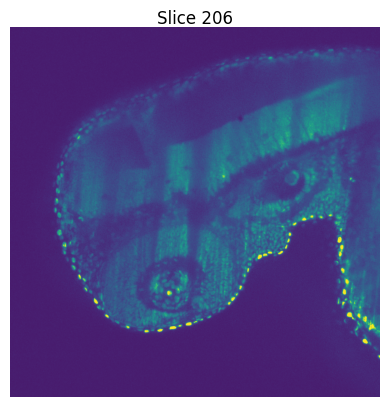

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, dpi=100)
ax.imshow(X[206], vmax = 500)
ax.set_title("Slice 206", fontsize=12, pad=1)
ax.axis("off")

We can observe that the stripes are along vertical (in the image space), and a little bit tilted. Hence, when training the DeStripe model, arguments `is_vertical` is True and `angle_offset` is set as -3.

[Leonardo-DeStripe] Backend: JAX | Device: gpu
Start DeStripe...

Please check the orientation of the stripes...


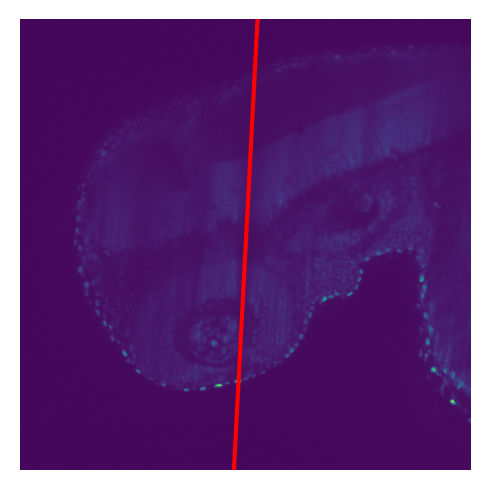

Done


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

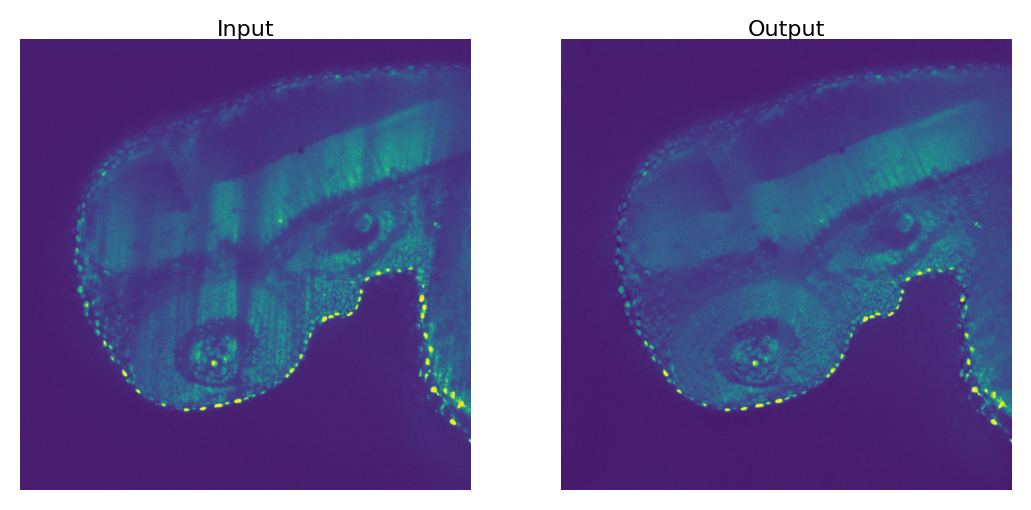

In [6]:
from leonardo_toolset import DeStripe

model = DeStripe()

recon = model.train(is_vertical = True,
                    display = False,
                    angle_offset = [-3],
                    x = X[206],
                    display_angle_orientation = True,
                    )

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.imshow(X[206], vmax = 500)
ax1.set_title("Input", fontsize=8, pad=1)
ax1.axis("off")
ax2.imshow(recon[0], vmax = 500)
ax2.set_title("Output", fontsize=8, pad=1)
ax2.axis("off")

Here, `DeStripe` is initialized using default, parameters. A more advanced list of available arguments can be found in section [API reference](https://leonardo-lsfm.readthedocs.io/en/latest/api.html). Note that it might be not very easy to set `angle_offset`. Hence, we additionally plot the used angle orientation before training the algorithm (red line). **It's important to double-check the orientation, and correct it if needed**.

In case of sample details, especially those along the stripe direction, are removed together with the stripes, Leonardo-DeStripe is able to do post-processing to keep sample details using the knowledge of illumination direction. To enable post-processing, please provide additional input argument `ill_orient` to the train(). Here the illumination comes from bottom in the image space and therefore `illu_orient="bottom"`.

[Leonardo-DeStripe] Backend: JAX | Device: gpu
Start DeStripe...

Please check the orientation of the stripes...


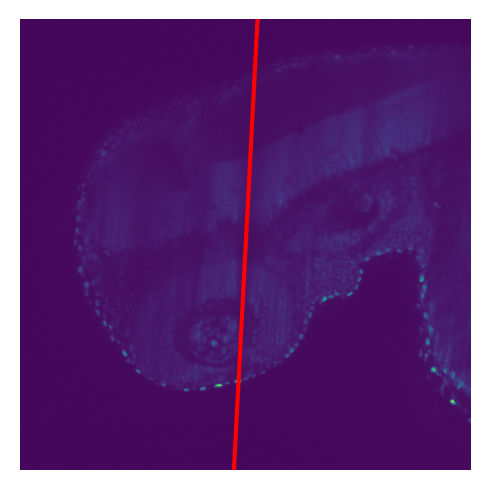

Done


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

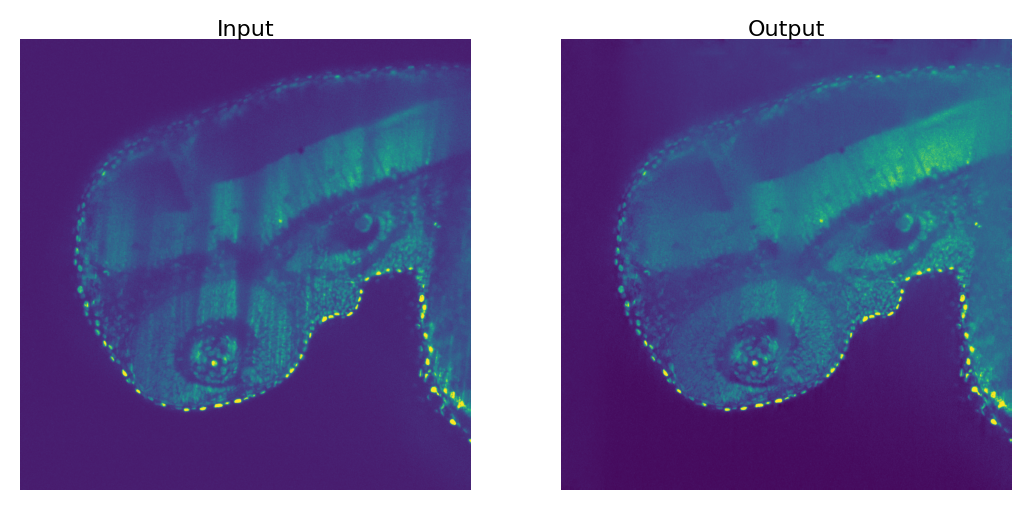

In [7]:
from leonardo_toolset import DeStripe

model = DeStripe()

recon = model.train(is_vertical = True,
                    display = False,
                    angle_offset = [-3],
                    x = X[206],
                    display_angle_orientation = True,
                    illu_orient = "bottom",
                    non_positive = True,
                    )

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.imshow(X[206], vmax = 500)
ax1.set_title("Input", fontsize=8, pad=1)
ax1.axis("off")
ax2.imshow(recon[0], vmax = 500)
ax2.set_title("Output", fontsize=8, pad=1)
ax2.axis("off")

## **Note 1: remove multi-directional stripes**

Sometimes, in some special light-sheet based systems, for example [Balze](https://www.miltenyibiotec.com/DE-en/products/ultramicroscope-blaze.html), multiple static light sheets are used simultaneously. Hence, there might be stripes along multiple directions (for example, 0, -10 and 10 degrees for Blaze) in the image. To remove all these stripes at the same time, simply use `angle_offset` to specify:
```
recon = model.train(...
                    angle_offset = [-10, 0, 10],
                    ...
                    )
```

## **Note 2: DeStripe for a whole image stack**

It's also easy to remove stripes for a whole image stack in a slice-by-slice fasion:
```
recon = model.train(...
                    X = X,  # X should be z-by-m-by-n
                    ...
                    )
```

It's also possible to provide the file name of the volume--to-be-processed:
```
recon = model.train(...
                    X = "volume-to-be-processed.tif"
                    ...
                    )
```